<a href="https://colab.research.google.com/github/giastoica/product-category-prediction/blob/main/notebooks/product_category_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project name: Product Category Prediction  

*Author*: Giorgiana Stoica  

This document details a machine learning project for predicting product categories from their titles. The project follows a clear sequence of steps: data cleaning, feature engineering, model training, and evaluation. It systematically compares several classification algorithms, selects one based on performance metrics, and uses it to predict categories for unlabeled data. The final output is a dataset with predicted category labels for products.


## 1. Initial Data Loading and Exploratory Analysis (EDA)

The initial steps involve loading the dataset, identifying missing values, and handling them by dropping rows with missing titles. The data is then correctly separated into a labeled set for training and an unlabeled set for future predictions. This ensures that the final model is trained exclusively on ground-truth data.

Dataset shape: (35311, 8)


,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Listing Date
0,1,apple iphone 8 plus 64gb silver,1,Mobile Phones,QA-2276-XC,860.0,2.5,5/10/2024
1,2,apple iphone 8 plus 64 gb spacegrau,2,Mobile Phones,KA-2501-QO,3772.0,4.8,12/31/2024
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,Mobile Phones,FP-8086-IE,3092.0,3.9,11/10/2024
3,4,apple iphone 8 plus 64gb space grey,4,Mobile Phones,YI-0086-US,466.0,3.4,5/2/2022
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,Mobile Phones,NZ-3586-WP,4426.0,1.6,4/12/2023


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35311 entries, 0 to 35310
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   product ID       35311 non-null  int64  
 1   Product Title    35139 non-null  object 
 2   Merchant ID      35311 non-null  int64  
 3   Category Label   35267 non-null  object 
 4   _Product Code    35216 non-null  object 
 5   Number_of_Views  35297 non-null  float64
 6   Merchant Rating  35141 non-null  float64
 7   Listing Date     35252 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 2.2+ MB

Missing values per column:
product ID           0
Product Title      172
Merchant ID          0
Category Label      44
_Product Code       95
Number_of_Views     14
Merchant Rating    170
Listing Date        59
dtype: int64


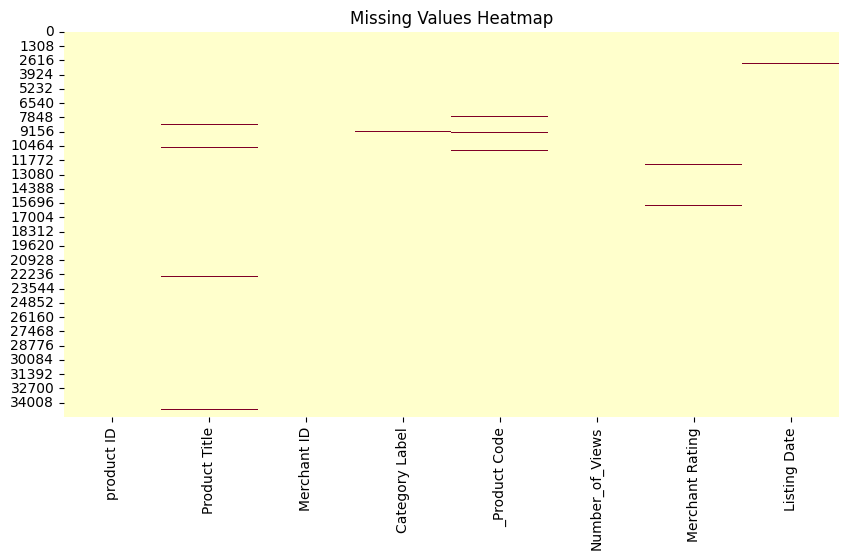

In [113]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import re
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.base import clone


# Load dataset
url = "https://raw.githubusercontent.com/giastoica/product-category-prediction/main/data/products.csv"
try:
    df = pd.read_csv(url)
except Exception as e:
    print(f"Error loading data from URL: {e}")

# Fix column names
df.columns = df.columns.str.strip()

print("Dataset shape:", df.shape)
display(df.head())
df.info()

# Missing values overview
print("\nMissing values per column:")
print(df.isna().sum())

plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False, cmap="YlOrRd")
plt.title("Missing Values Heatmap")
plt.show()


## 2. Comprehensive Data Cleaning and Separation

This is a single, unified cell for all data cleaning tasks, eliminating the repetition from the original code. It applies the suggested strategy: dropping rows with missing titles, separating data for training and future prediction, and imputing missing numeric values.

In [114]:
# Drop rows with missing Product Title
df_clean = df.dropna(subset=["Product Title"]).copy()

# Split into training and unlabeled
df_train = df_clean[df_clean["Category Label"].notna()].copy()
df_unlabeled = df_clean[df_clean["Category Label"].isna()].copy()

# Normalize labels
df_train.loc[:, "Category Label"] = df_train["Category Label"].str.lower()

# Impute numeric fields
for col in ["Number_of_Views", "Merchant Rating"]:
    median_value = df_train[col].median()
    df_train[col] = df_train[col].fillna(median_value)
    df_unlabeled[col] = df_unlabeled[col].fillna(median_value)

# Convert dates
df_train["Listing Date"] = pd.to_datetime(df_train["Listing Date"], format="%m/%d/%Y", errors="coerce")
df_unlabeled["Listing Date"] = pd.to_datetime(df_unlabeled["Listing Date"], format="%m/%d/%Y", errors="coerce")

# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_unlabeled.reset_index(drop=True, inplace=True)

df_train.info()
df_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35096 entries, 0 to 35095
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   product ID       35096 non-null  int64         
 1   Product Title    35096 non-null  object        
 2   Merchant ID      35096 non-null  int64         
 3   Category Label   35096 non-null  object        
 4   _Product Code    35002 non-null  object        
 5   Number_of_Views  35096 non-null  float64       
 6   Merchant Rating  35096 non-null  float64       
 7   Listing Date     35038 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 2.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   product ID       43 non-null     int64         
 1   Product Title  

## 3. Feature Engineering
This step is crucial for transforming raw text and date data into a numerical format that machine learning models can process. Features such as Title Word Count, Has Numbers, and Listing Month are created from the original Product Title and Listing Date columns. These engineered features provide the model with additional information to improve its predictive power.

In [115]:
# List of common brands
brands = ['Acer', 'Apple', 'Dell', 'HP', 'Lenovo', 'Samsung', 'Sony', 'LG', 'Microsoft', 'Nikon']

def has_special_chars(text):
    return 1 if re.search(r'[!@#$%^&*()_+={}\[\]:;"\'<,>/?\\|`~]', text) else 0

def has_all_caps_word(text):
    return 1 if any(word.isupper() and len(word) > 1 for word in text.split()) else 0

def feature_engineer(df):
    df_copy = df.copy()
    df_copy['Title Word Count'] = df_copy['Product Title'].apply(lambda x: len(x.split()))
    df_copy['Title Char Count'] = df_copy['Product Title'].apply(len)
    df_copy['Has Numbers'] = df_copy['Product Title'].apply(lambda x: int(any(char.isdigit() for char in x)))
    df_copy['Has Special Chars'] = df_copy['Product Title'].apply(has_special_chars)
    df_copy['Has All Caps Word'] = df_copy['Product Title'].apply(has_all_caps_word)
    df_copy['Longest Word Length'] = df_copy['Product Title'].apply(lambda x: max((len(word) for word in x.split()), default=0))
    df_copy['Is Brand Mentioned'] = df_copy['Product Title'].apply(lambda x: int(any(brand.lower() in x.lower() for brand in brands)))
    df_copy['Listing Date'] = pd.to_datetime(df_copy['Listing Date'], errors='coerce')
    df_copy['Listing Month'] = df_copy['Listing Date'].dt.month
    df_copy['Listing Day of Week'] = df_copy['Listing Date'].dt.dayofweek
    return df_copy.drop(columns=['Listing Date'])

# Apply
df_train_enriched = feature_engineer(df_train)
df_unlabeled_enriched = feature_engineer(df_unlabeled)

display(df_train_enriched.head())

,product ID,Product Title,Merchant ID,Category Label,_Product Code,Number_of_Views,Merchant Rating,Title Word Count,Title Char Count,Has Numbers,Has Special Chars,Has All Caps Word,Longest Word Length,Is Brand Mentioned,Listing Month,Listing Day of Week
0,1,apple iphone 8 plus 64gb silver,1,mobile phones,QA-2276-XC,860.0,2.5,6,31,1,0,0,6,1,5.0,4.0
1,2,apple iphone 8 plus 64 gb spacegrau,2,mobile phones,KA-2501-QO,3772.0,4.8,7,35,1,0,0,9,1,12.0,1.0
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,mobile phones,FP-8086-IE,3092.0,3.9,13,70,1,1,0,10,1,11.0,6.0
3,4,apple iphone 8 plus 64gb space grey,4,mobile phones,YI-0086-US,466.0,3.4,7,35,1,0,0,6,1,5.0,0.0
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,mobile phones,NZ-3586-WP,4426.0,1.6,11,54,1,0,0,8,1,4.0,2.0




## 4. Feature Setup

We will use:
- **Text feature**: Product Title (processed with TF-IDF)
- **Numeric features**: Engineered metadata from titles and listing dates

In [116]:
# Define features
text_feature = "Product Title"
numeric_features = [
    "Title Word Count", "Title Char Count", "Has Numbers",
    "Has Special Chars", "Has All Caps Word", "Longest Word Length",
    "Is Brand Mentioned", "Listing Month", "Listing Day of Week"
]

# Combine all features
all_features = [text_feature] + numeric_features

X = df_train_enriched[all_features]
y = df_train_enriched["Category Label"]


## 5. Train-Test Split

In [117]:
X_train_enriched, X_test_enriched, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train set shape:", X_train_enriched.shape)
print("Test set shape:", X_test_enriched.shape)


Train set shape: (28076, 10)
Test set shape: (7020, 10)


## Visualise the class distribution

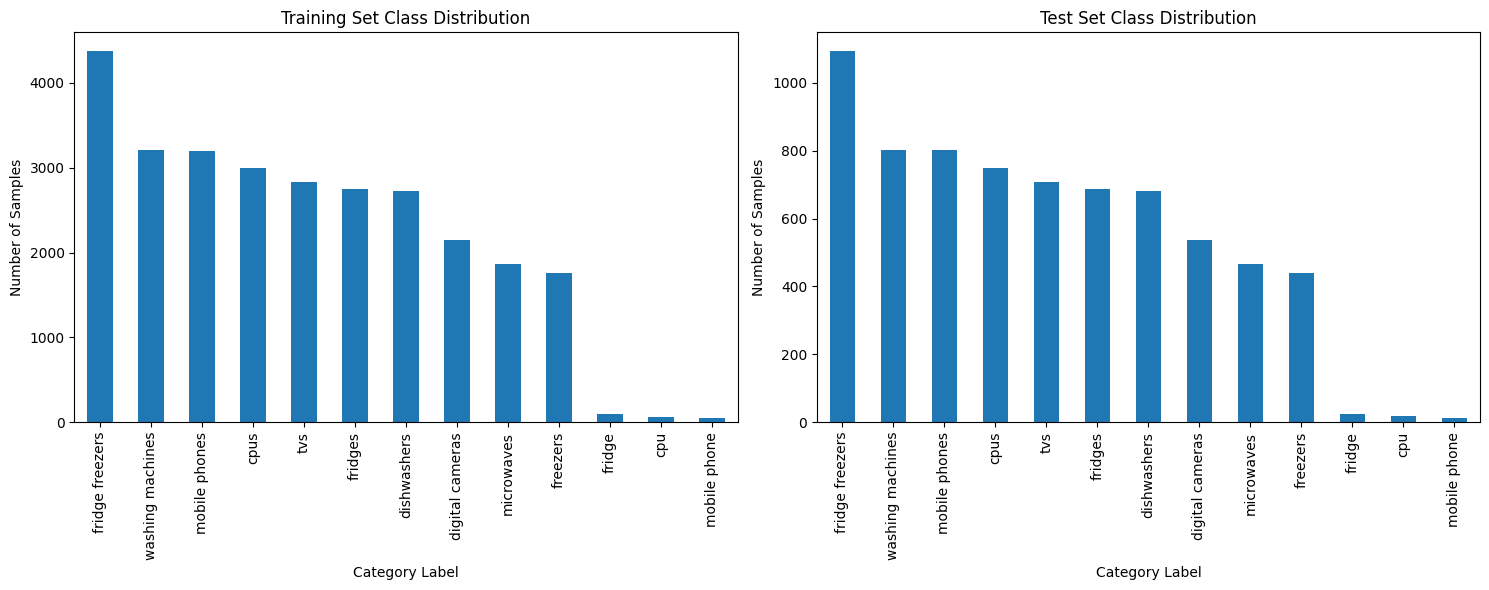

Training set class counts:
 Category Label
fridge freezers     4376
washing machines    3212
mobile phones       3201
cpus                2998
tvs                 2833
fridges             2749
dishwashers         2724
digital cameras     2151
microwaves          1862
freezers            1761
fridge                98
cpu                   67
mobile phone          44
Name: count, dtype: int64

Test set class counts:
 Category Label
fridge freezers     1094
washing machines     803
mobile phones        801
cpus                 749
tvs                  708
fridges              687
dishwashers          681
digital cameras      538
microwaves           466
freezers             440
fridge                25
cpu                   17
mobile phone          11
Name: count, dtype: int64


In [118]:
# Get the count of each unique label in the training and test sets
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot the training set class distribution
train_counts.plot(kind='bar', ax=ax[0])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Category Label')
ax[0].set_ylabel('Number of Samples')

# Plot the test set class distribution
test_counts.plot(kind='bar', ax=ax[1])
ax[1].set_title('Test Set Class Distribution')
ax[1].set_xlabel('Category Label')
ax[1].set_ylabel('Number of Samples')

plt.tight_layout()
plt.show()

print("Training set class counts:\n", train_counts)
print("\nTest set class counts:\n", test_counts)

## 6. Preprocessing Pipeline

A preprocessing pipeline is constructed using ColumnTransformer and Pipeline. This approach applies different transformations to different columns (e.g., TF-IDF for text and scaling for numeric features) in a single, consistent workflow. This also prevents data leakage, a common issue where information from the test set can inadvertently influence the training process.


In [119]:
preprocessor = ColumnTransformer(
    transformers=[
        ("title_tfidf", TfidfVectorizer(stop_words="english", max_features=5000), text_feature),
        ("numeric", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler())
        ]), numeric_features)
    ]
)

## 7. Model Training & Evaluation

The project trains and evaluates multiple machine learning models, including Logistic Regression and Random Forest. The performance of each model is assessed using a classification_report and a confusion matrix heatmap, which provides a detailed view of the prediction accuracy for each product category.

In [120]:
# Update the models to use the 'balanced' class_weight
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, n_jobs=-1, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_jobs=-1, class_weight='balanced'),
    # Naive Bayes and LinearSVC do not have a class_weight parameter
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(class_weight='balanced')

}
# we've implemented the class_weight='balanced' parameter in the model definitions. This tells the machine learning algorithms to automatically adjust the weights of the classes. Specifically, it assigns higher importance to
# the minority classes and lower importance to the majority classes during training.
# This re-weighting encourages the model to pay more attention to the underrepresented categories, helping it to better identify and predict them. This change should:


for name, model in models.items():
    print(f"\n{name}")
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])
    pipeline.fit(X_train_enriched, y_train)
    y_pred = pipeline.predict(X_test_enriched)
    print(classification_report(y_test, y_pred))


Logistic Regression
                  precision    recall  f1-score   support

             cpu       0.01      0.06      0.02        17
            cpus       0.98      0.89      0.93       749
 digital cameras       0.99      0.99      0.99       538
     dishwashers       0.92      0.96      0.94       681
        freezers       0.92      0.94      0.93       440
          fridge       0.01      0.04      0.01        25
 fridge freezers       0.96      0.88      0.92      1094
         fridges       0.84      0.75      0.79       687
      microwaves       0.97      0.97      0.97       466
    mobile phone       0.03      0.18      0.05        11
   mobile phones       0.96      0.91      0.94       801
             tvs       0.97      0.99      0.98       708
washing machines       0.96      0.93      0.94       803

        accuracy                           0.91      7020
       macro avg       0.73      0.73      0.72      7020
    weighted avg       0.94      0.91      0.92  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

             cpu       0.00      0.00      0.00        17
            cpus       0.98      1.00      0.99       749
 digital cameras       0.99      0.99      0.99       538
     dishwashers       0.95      0.94      0.95       681
        freezers       1.00      0.55      0.70       440
          fridge       0.00      0.00      0.00        25
 fridge freezers       0.74      0.95      0.83      1094
         fridges       0.85      0.79      0.82       687
      microwaves       1.00      0.95      0.97       466
    mobile phone       0.00      0.00      0.00        11
   mobile phones       0.98      0.98      0.98       801
             tvs       0.96      0.99      0.98       708
washing machines       0.97      0.93      0.95       803

        accuracy                           0.92      7020
       macro avg       0.72      0.70      0.70      7020
    weighted avg       0.92      0.92      0.91      7020


Support Ve

In [121]:
## 7b. Model Performance Visualization


Logistic Regression Classification Report:
                  precision    recall  f1-score   support

             cpu       0.01      0.06      0.02        17
            cpus       0.98      0.89      0.93       749
 digital cameras       0.99      0.99      0.99       538
     dishwashers       0.92      0.96      0.94       681
        freezers       0.92      0.94      0.93       440
          fridge       0.01      0.04      0.01        25
 fridge freezers       0.96      0.88      0.92      1094
         fridges       0.84      0.75      0.79       687
      microwaves       0.97      0.97      0.97       466
    mobile phone       0.03      0.18      0.05        11
   mobile phones       0.96      0.91      0.94       801
             tvs       0.97      0.99      0.98       708
washing machines       0.96      0.93      0.94       803

        accuracy                           0.91      7020
       macro avg       0.73      0.73      0.72      7020
    weighted avg       0.9

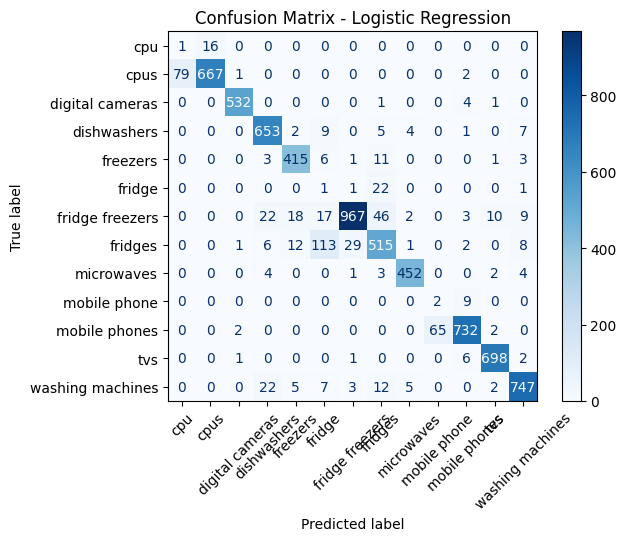


Decision Tree Classification Report:
                  precision    recall  f1-score   support

             cpu       0.03      0.06      0.04        17
            cpus       0.97      0.95      0.96       749
 digital cameras       0.99      0.96      0.98       538
     dishwashers       0.95      0.94      0.95       681
        freezers       0.88      0.91      0.90       440
          fridge       0.03      0.04      0.03        25
 fridge freezers       0.91      0.91      0.91      1094
         fridges       0.84      0.80      0.82       687
      microwaves       0.94      0.95      0.95       466
    mobile phone       0.00      0.00      0.00        11
   mobile phones       0.92      0.96      0.94       801
             tvs       0.98      0.96      0.97       708
washing machines       0.94      0.93      0.94       803

        accuracy                           0.92      7020
       macro avg       0.72      0.72      0.72      7020
    weighted avg       0.93     

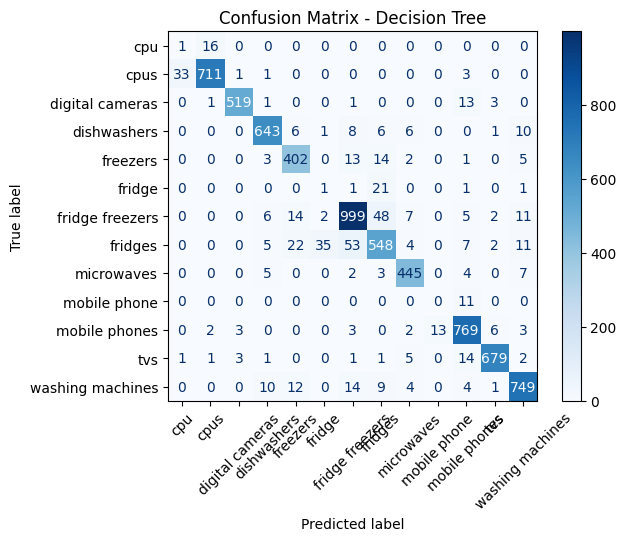


Random Forest Classification Report:
                  precision    recall  f1-score   support

             cpu       0.00      0.00      0.00        17
            cpus       0.98      1.00      0.99       749
 digital cameras       0.99      0.98      0.99       538
     dishwashers       0.95      0.96      0.95       681
        freezers       0.93      0.92      0.93       440
          fridge       0.00      0.00      0.00        25
 fridge freezers       0.93      0.92      0.93      1094
         fridges       0.85      0.88      0.87       687
      microwaves       0.97      0.96      0.97       466
    mobile phone       0.00      0.00      0.00        11
   mobile phones       0.95      0.99      0.97       801
             tvs       0.99      0.99      0.99       708
washing machines       0.95      0.95      0.95       803

        accuracy                           0.95      7020
       macro avg       0.73      0.73      0.73      7020
    weighted avg       0.94     

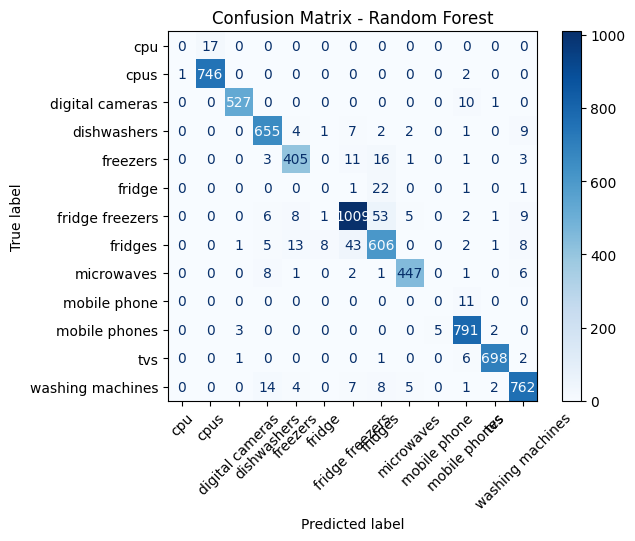


Naive Bayes Classification Report:
                  precision    recall  f1-score   support

             cpu       0.00      0.00      0.00        17
            cpus       0.98      1.00      0.99       749
 digital cameras       0.99      0.99      0.99       538
     dishwashers       0.95      0.94      0.95       681
        freezers       1.00      0.55      0.70       440
          fridge       0.00      0.00      0.00        25
 fridge freezers       0.74      0.95      0.83      1094
         fridges       0.85      0.79      0.82       687
      microwaves       1.00      0.95      0.97       466
    mobile phone       0.00      0.00      0.00        11
   mobile phones       0.98      0.98      0.98       801
             tvs       0.96      0.99      0.98       708
washing machines       0.97      0.93      0.95       803

        accuracy                           0.92      7020
       macro avg       0.72      0.70      0.70      7020
    weighted avg       0.92      0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


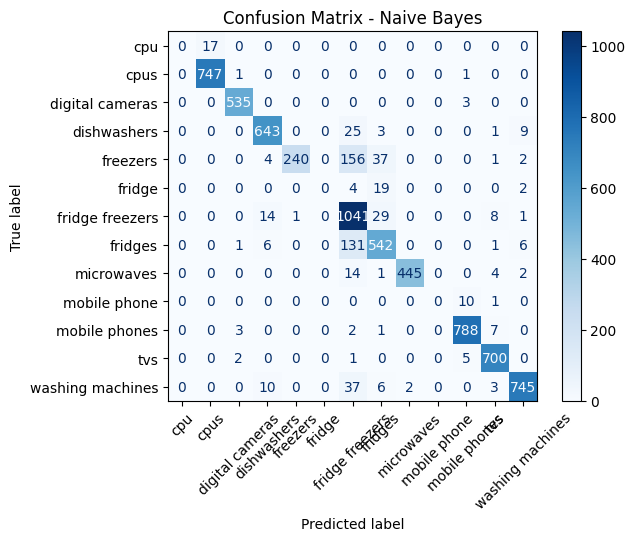


Support Vector Machine Classification Report:
                  precision    recall  f1-score   support

             cpu       0.00      0.00      0.00        17
            cpus       0.98      0.98      0.98       749
 digital cameras       0.99      1.00      1.00       538
     dishwashers       0.92      0.96      0.94       681
        freezers       0.94      0.94      0.94       440
          fridge       0.02      0.04      0.03        25
 fridge freezers       0.96      0.93      0.94      1094
         fridges       0.88      0.87      0.88       687
      microwaves       0.99      0.97      0.98       466
    mobile phone       0.10      0.09      0.10        11
   mobile phones       0.98      0.99      0.98       801
             tvs       0.99      0.99      0.99       708
washing machines       0.97      0.94      0.95       803

        accuracy                           0.95      7020
       macro avg       0.75      0.75      0.75      7020
    weighted avg       

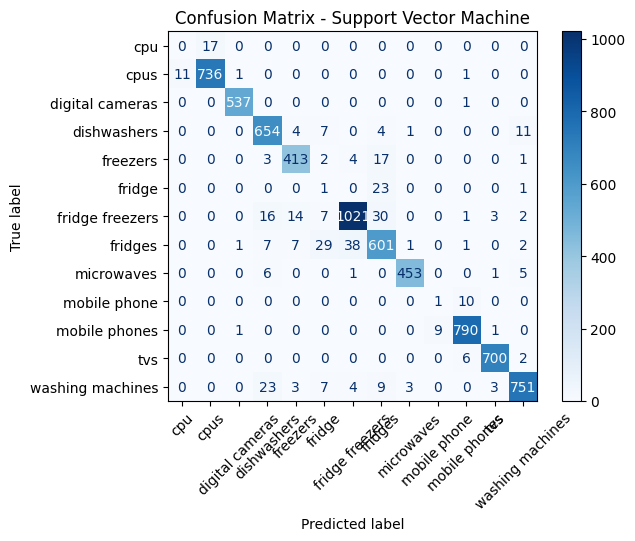

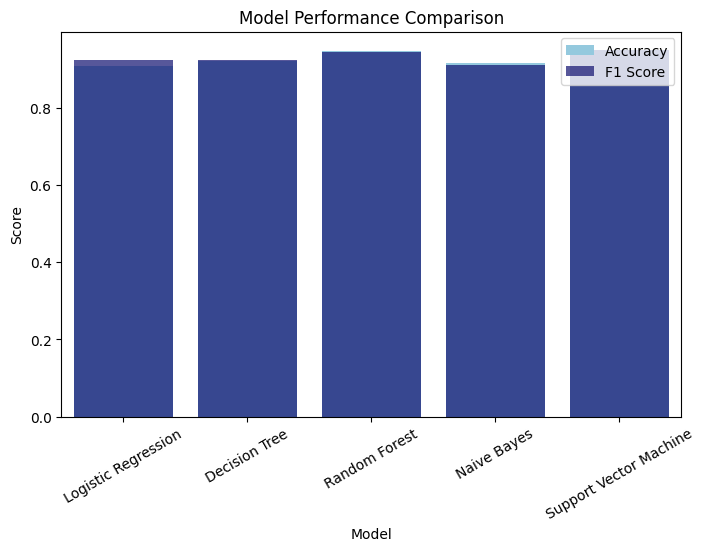

,Model,Accuracy,F1 Score
0,Logistic Regression,0.909117,0.924332
1,Decision Tree,0.921083,0.923092
2,Random Forest,0.946724,0.944267
3,Naive Bayes,0.915385,0.910479
4,Support Vector Machine,0.948433,0.949789


In [122]:
# Store results for comparison
results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])

    pipeline.fit(X_train_enriched, y_train)
    y_pred = pipeline.predict(X_test_enriched)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  # weighted handles class imbalance

    results.append({"Model": name, "Accuracy": acc, "F1 Score": f1})

    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipeline.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Convert results into a DataFrame for plotting
results_df = pd.DataFrame(results)

# Barplot comparison
plt.figure(figsize=(8,5))
sns.barplot(x="Model", y="Accuracy", data=results_df, color="skyblue", label="Accuracy")
sns.barplot(x="Model", y="F1 Score", data=results_df, color="navy", alpha=0.7, label="F1 Score")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=30)
plt.legend()
plt.show()

display(results_df)

## 8. Select Best Model for Final Predictions

The model with the highest weighted F1 score on the test set is selected as the best model. This metric is particularly useful for multiclass classification tasks, as it provides a balanced measure of precision and recall.

In [123]:
# Track best model
best_model_name = None
best_model = None
best_score = -1.0

for name, model in models.items():
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", clone(model))  # clone to avoid refitting issues
    ])

    pipeline.fit(X_train_enriched, y_train)
    y_pred = pipeline.predict(X_test_enriched)

    f1 = f1_score(y_test, y_pred, average="weighted")

    if f1 > best_score:
        best_score = f1
        best_model_name = name
        best_model = pipeline

print(f"\n✅ Best model: {best_model_name} (Weighted F1 = {best_score:.4f})")

# Save predictions on test set
y_test_pred = best_model.predict(X_test_enriched)

# Evaluate again for clarity
print("\nFinal Evaluation of Best Model:")
print(classification_report(y_test, y_test_pred))



✅ Best model: Support Vector Machine (Weighted F1 = 0.9498)

Final Evaluation of Best Model:
                  precision    recall  f1-score   support

             cpu       0.00      0.00      0.00        17
            cpus       0.98      0.98      0.98       749
 digital cameras       0.99      1.00      1.00       538
     dishwashers       0.92      0.96      0.94       681
        freezers       0.94      0.94      0.94       440
          fridge       0.02      0.04      0.03        25
 fridge freezers       0.96      0.93      0.94      1094
         fridges       0.88      0.87      0.88       687
      microwaves       0.99      0.97      0.98       466
    mobile phone       0.10      0.09      0.10        11
   mobile phones       0.98      0.99      0.98       801
             tvs       0.99      0.99      0.99       708
washing machines       0.97      0.94      0.95       803

        accuracy                           0.95      7020
       macro avg       0.75      0

## 8b. Confusion Matrix and Heatmap for the Best Model

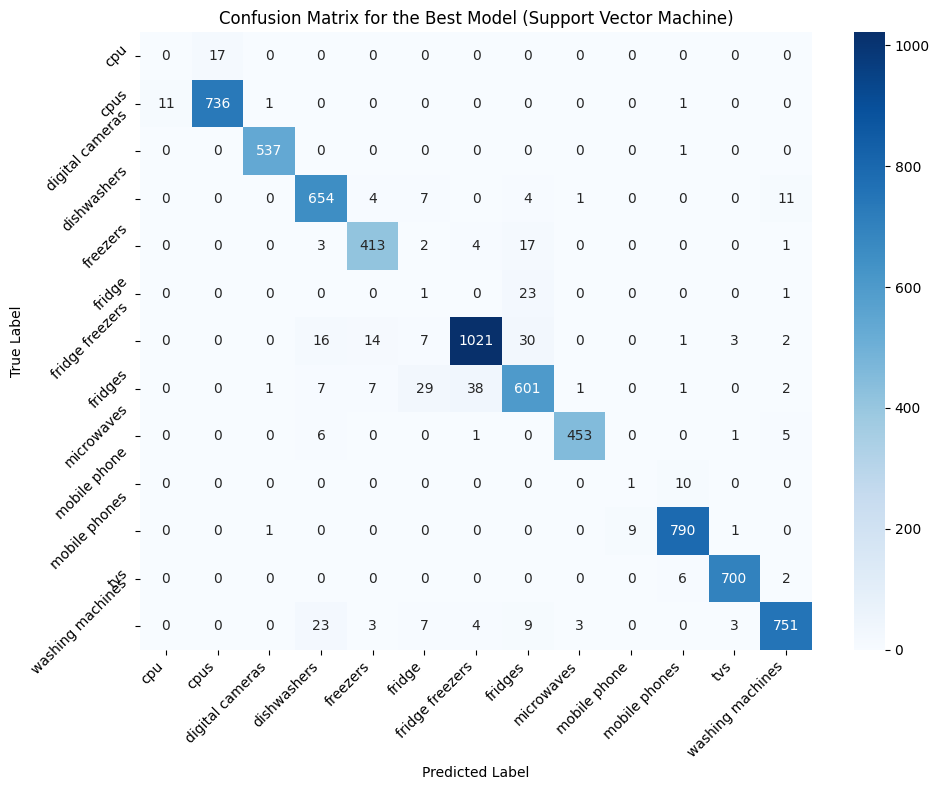

In [124]:
# Get the labels from the best model's classes
labels = best_model.classes_

# Create the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=labels)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title(f'Confusion Matrix for the Best Model ({best_model_name})')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Interpretation of the Heatmap
Diagonal Cells: The values on the main diagonal of the heatmap represent the number of correct predictions for each category. For example, the top-left cell shows how many products from the "laptops" category were correctly predicted as "laptops." The higher these numbers are, the better the model's performance.

Off-Diagonal Cells: These cells show the misclassifications. For instance, a value in the row for "smartphones" and the column for "tablets" indicates how many actual smartphones were incorrectly classified as tablets. Analyzing these values helps identify which categories the model struggles to distinguish.

## 9. Predict Category for Unlabeled Data

In [125]:
# Ensure we have the best model trained already
if best_model is None:
    raise ValueError("Best model not found. Run model selection first.")

# Define features for unlabeled data
X_unlabeled = df_unlabeled_enriched[all_features]

# Predict categories
unlabeled_predictions = best_model.predict(X_unlabeled)

# Add predictions to the DataFrame
df_unlabeled_enriched["Predicted Category Label"] = unlabeled_predictions

print("Sample predictions on unlabeled data:")
display(df_unlabeled_enriched[["Product Title", "Predicted Category Label"]].head(10))

Sample predictions on unlabeled data:


,Product Title,Predicted Category Label
0,apple iphone 7 4.7 single sim 4g 2gb 128gb 196...,mobile phone
1,cat s60 11.9 cm 4.7 1280 x 720 pixels flat 16 ...,mobile phones
2,microsoft lumia 650 lte black,mobile phones
3,motorola moto x style,mobile phones
4,doro phoneeasy 615 black,mobile phones
5,sony xperia c4,mobile phones
6,boxed processor amd ryzen 3 1200 4 x 3.1 ghz quad,cpus
7,intel core i5 4570te 2.7 ghz 2 cores 4 threads...,cpus
8,intel core i3 i3 3250 dual core 2 core 3.50 gh...,cpus
9,amd opteron 6262 he processor,cpus


## 10. Save Results

In [126]:
# Save the dataset with predictions
df_unlabeled_enriched.to_csv("unlabeled_with_predictions.csv", index=False)

print("Predictions saved to 'unlabeled_with_predictions.csv'")

Predictions saved to 'unlabeled_with_predictions.csv'


Final Prediction: The selected best model is used to predict the categories for the df_unlabeled_enriched dataset, fulfilling the project's primary objective. The final predictions are added to the DataFrame and saved to a CSV file for future use.



# 11. Conclusion

This document provides a complete and logical walkthrough of a machine learning project for product category prediction. The methodology covers all key stages from data preparation to final prediction, resulting in a dataset of product titles with their predicted categories.